# Tuning MCTS params to support policy training

We are using the Upper Confidence Bound for MCTS

$$
U(s, a) = Q(s, a) + c_{puct} P(s, a) \frac{\sqrt{\sum_b N(s, b)}}{1 + N(s, a)}
$$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from tqdm import tqdm

from aegomoku.gomoku_board import GomokuBoard
from aegomoku.gomoku_game import ConstantBoardInitializer, GomokuGame as Game
from aegomoku.interfaces import MctsParams, PolicyParams
from aegomoku.mcts import MCTS
from aegomoku.gomoku_players import PolicyAdvisedGraphSearchPlayer
from aegomoku.policies.topological_value import TopologicalValuePolicy
from aegomoku.utils import analyse_board

2022-10-02 18:37:13.219244: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
BOARD_SIZE=19

---
### The initial board

In [4]:
# Yixin says: This is a 100% win for white - I guess we're not quite there, yet...;-(
# stones = "C11F9E9G8F7G7G9H8"
stones = "C11F9E9G8F7G7G9H8I8H7I6I9F6H6H9I5J4"
# stones = "H8G8"
stones = [256, 276, 238, 240, 219, 237, 184, 199]

2022-10-02 18:37:19.357336: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


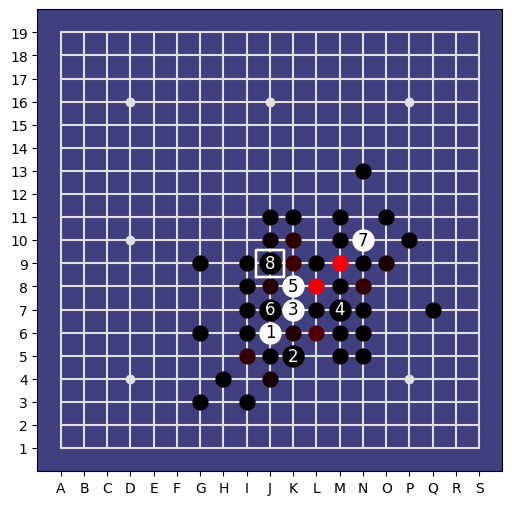

In [5]:
from aegomoku.gomoku_game import Swap2

the_game = Swap2(BOARD_SIZE)
policy = TopologicalValuePolicy(game=the_game)

analyse_board(BOARD_SIZE, stones, policy, disp_width=6, policy_cutoff=.01)

In [6]:
mcts_params = MctsParams(cpuct=1.0, num_simulations=400, temperature=1.0)
player = PolicyAdvisedGraphSearchPlayer("Tester", the_game, mcts_params, adviser=policy)

In [7]:
from aegomoku.gomoku_game import Swap2GameState

game_state = Swap2GameState()
board = GomokuBoard(BOARD_SIZE, game_state, stones=stones)
game_state.board = board

---

# Essential Parameter: MCTS score read-out temperature
A readout temperature between 4 and 6 will produce a reasonable input for future advice!

In [8]:
compare = True

In [9]:
compare = False

In [10]:
if compare:
    print("Policy with decreasing readout temperature")
    player.refresh()
    player.mcts.get_action_prob(board)
    for t in tqdm(range(10, -1, -2)):
        probs, v = player.evaluate(board, t)
        analyse_board(BOARD_SIZE, stones, probs, disp_width=6, policy_cutoff=.01)

## A TestAdviser

In [11]:
from aegomoku.tests.advice import TestAdviser

In [12]:
game_state = Swap2GameState()
game_state.PASS = BOARD_SIZE * BOARD_SIZE
game_state.YIELD = game_state.PASS + 1
PASS = game_state.PASS
YIELD = game_state.YIELD
board = GomokuBoard(BOARD_SIZE, game_state, stones="")
game_state.board = board

In [13]:
adviser = TestAdviser(board, [101, 41, 102, 42, YIELD, 103, 199, 104, 200],
                      game= the_game, fallback=policy)

The test adviser will select the moves as given in the constructor.

In [22]:
state = board.canonical_representation()
moves = adviser.get_advisable_actions(state)
if moves[0] is not None:
    board.act(moves[0])
    state = board.canonical_representation()
    field, phase = state
    board.plot()
    print(board.get_string_representation())
    print(phase)
    special_moves = the_game.get_valid_moves(board)[-2:]
    print(f"Valid special moves: {special_moves}")
    moves = adviser.get_advisable_actions(state)
    print(f"Advice: {moves[0]}")

                                                                 
19    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
18    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
17    .  .  .  O  O  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
16    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
15    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
14    .  .  .  .  .  .  X  X  X  X  .  .  .  .  .  .  .  .  .    
13    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
12    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
11    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
10    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 9    .  .  .  .  .  .  .  .  .  O [O] .  .  .  .  .  .  .  .    
 8    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 7    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 6    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 5    .  .

# Testing the value backpropagation for Swap2

KeyboardInterrupt: 

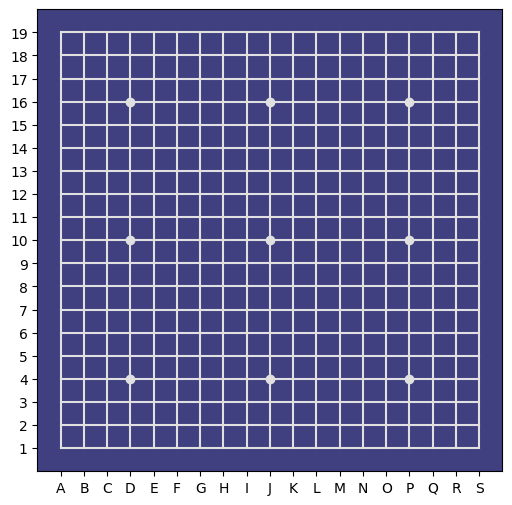

In [26]:
analyse_board(BOARD_SIZE, stones=board.get_stones(), policy=policy)

In [25]:
board.get_stones()

[G14, D17, H14, E17, Yield, I14, J9, J14, K9]

In [36]:
from aegomoku.gomoku_game import ConstantBoardInitializer
from aegomoku.mcts import MCTS, MctsParams

cbi = ConstantBoardInitializer(stones='')
game = Swap2(board_size=BOARD_SIZE, initializer=cbi)
mcts_params = MctsParams(cpuct=4.0, num_simulations=10, temperature=0)
mcts = MCTS(game, adviser=adviser, params=mcts_params)
board = game.get_initial_board()
board

 - Next: player 1 with black

### Play

In [37]:
pi = mcts.get_action_prob(board, temperature=1.0)

KeyboardInterrupt: 

In [27]:
import numpy as np
from tqdm import tqdm

done = game.get_winner(board)

for episode_step in tqdm(range(50)):
    t = 1.0
    pi = mcts.get_action_prob(board, temperature=t)
    action = np.random.choice(len(pi), p=pi)

    board.act(action)
    done = game.get_winner(board)
    if done is not None:
        print("We have a winner!")
        break

  0%|          | 0/50 [00:02<?, ?it/s]

KeyboardInterrupt

